# 3.4 长短期记忆网络

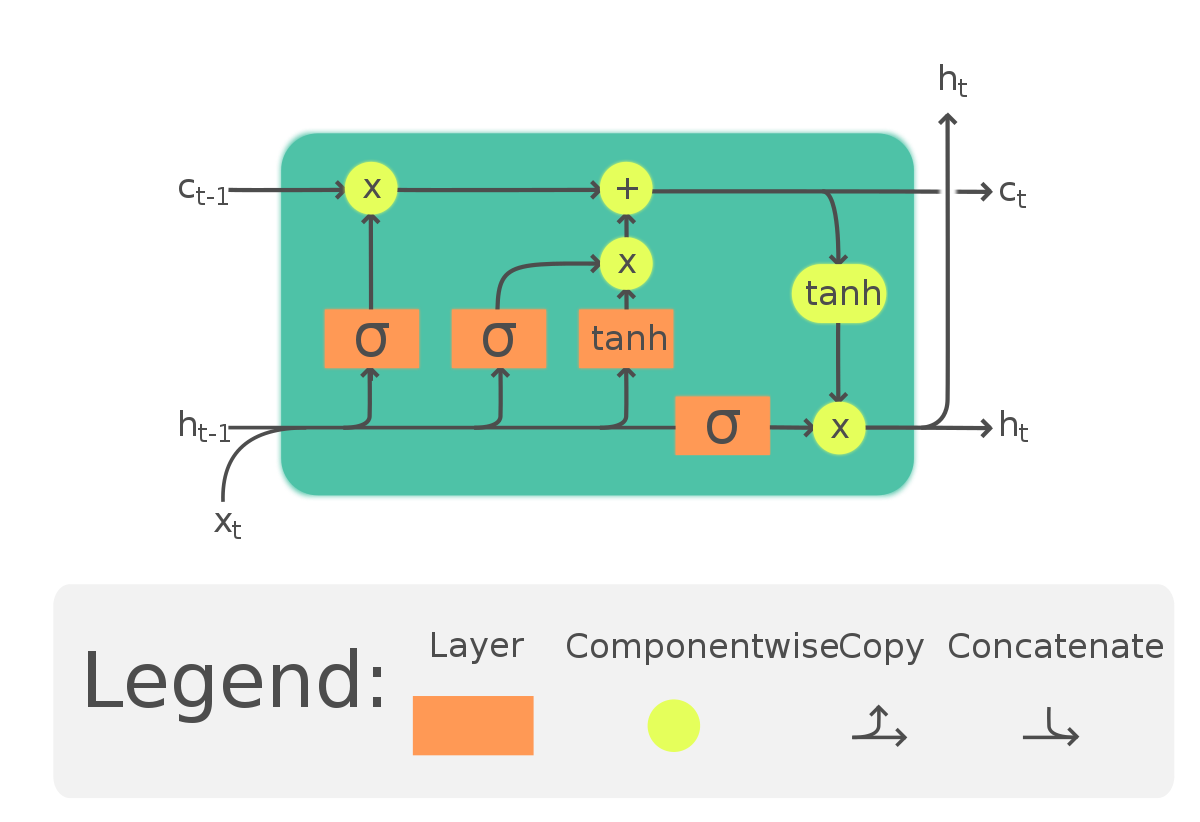

LSTM（长短期记忆网络）是一种特殊类型的循环神经网络（RNN），用于处理和预测序列数据中的时间相关性。LSTM由Hochreiter和Schmidhuber在1997年首次提出，旨在解决传统RNN在处理长期依赖问题时遇到的困难。LSTM的关键在于其内部结构，特别是它如何能够在长时间间隔内保持信息，这使得它在多种序列数据任务中表现出色，如语言翻译、语音识别、时间序列预测等。

LSTM的关键组件
LSTM网络的核心是由三个门控制的单元组成：输入门、遗忘门和输出门。这些门的功能允许LSTM单元决定何时更新其内部状态，何时遗忘无关的信息，以及何时将信息输出到下一层。

遗忘门：负责决定从单元状态中丢弃哪些信息。它通过查看当前输入和上一个输出来生成一个在0和1之间的值，其中0表示完全忘记，而1表示完全保留。

输入门：负责更新单元状态。首先，一个激活函数决定哪些值将更新，然后一个候选值被创建，与前一步的输出相乘，最后添加到单元状态。

输出门：决定基于单元的当前状态，下一个隐藏状态（即下一个时间步的输出）应该是什么。这决定了哪些部分的单元状态将用于输出。

看上去很复杂，实际上实现起来也不简单，这将是我们在实现transformer前结构最复杂的模型，让我手把手的教你实现LSTM,首先我们来导入依赖项

In [1]:
import sys
sys.path.append('.')

In [2]:
import numpy as np
import mytorch
from mytorch import Tensor, nn
import mytorch.nn.functional as F

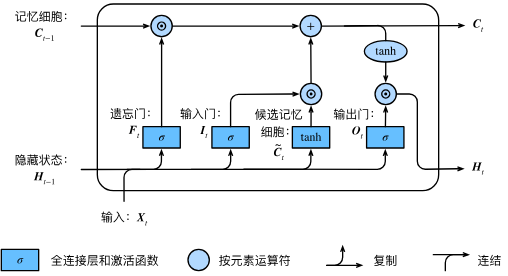

In [3]:
class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        # 输入门
        self.W_xi = nn.Linear(input_size, hidden_size)
        self.W_hi = nn.Linear(hidden_size, hidden_size, bias=False)

        # 遗忘门
        self.W_xf = nn.Linear(input_size, hidden_size)
        self.W_hf = nn.Linear(hidden_size, hidden_size, bias=False)

        # 输出门
        self.W_xo = nn.Linear(input_size, hidden_size)
        self.W_ho = nn.Linear(hidden_size, hidden_size, bias=False)

        # 候选记忆细胞
        self.W_xc = nn.Linear(input_size, hidden_size)
        self.W_hc = nn.Linear(hidden_size, hidden_size, bias=False)

        # 输出门参数
        self.W_hq = nn.Linear(hidden_size, output_size)

    def forward(self, x, init_states):
        h_prev, c_prev = init_states
        I = mytorch.sigmoid(self.W_xi(x) + self.W_hi(h_prev))
        F = mytorch.sigmoid(self.W_xf(x) + self.W_hf(h_prev))
        O = mytorch.sigmoid(self.W_xo(x) + self.W_ho(h_prev))
        C_tilda = mytorch.tanh(self.W_xc(x) + self.W_hc(h_prev))
        C = F * c_prev + I * C_tilda
        H = O * C.tanh()
        Y = self.W_hq(H)
        return Y, H, C

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.lstm_cell = LSTMCell(input_size, hidden_size, output_size)

    def forward(self, inputs, init_states=None):
        # 初始化状态
        batch_size = inputs.size(0)
        seq_len = inputs.size(1)
        if init_states is None:
            h_prev = mytorch.zeros(batch_size, self.lstm_cell.hidden_size)
            c_prev = mytorch.zeros(batch_size, self.lstm_cell.hidden_size)
        else:
            h_prev, c_prev = init_states

        outputs = []
        h_states = []
        c_states = []

        for t in range(seq_len):
            x = inputs[:, t, :]
            y, h_prev, c_prev = self.lstm_cell(x, (h_prev, c_prev))
            outputs.append(y.unsqueeze(1))
            h_states.append(h_prev.unsqueeze(1))
            c_states.append(c_prev.unsqueeze(1))

        outputs = mytorch.cat(outputs, dim=1)
        h_states = mytorch.cat(h_states, dim=1)
        c_states = mytorch.cat(c_states, dim=1)

        return outputs, (h_states, c_states)